# Preprocessing

## Importo le librerie utili

In [1]:
#La keyword import mi permette di utilizzare le funzioni presenti in altre librerie all'interno del mio script
#NB: Le librerie prima vanno scaricate

import numpy as np
import os
import pandas as pd
import mne

from mne.preprocessing import ICA

#Per utilizzare una funzione da queste librerie devo scrivere: nome_libreria.nome_funzione()

## Importo l'EEG del paziente che voglio studiare

In [7]:
#creo una stringa di testo contenente l'indirizzo della cartella dove sono gli eeg
#Se avete messo il dataset nella stessa cartella del notebook potete usare questa riga, crea la stringa contenente il percorso
#della working directory
#home_path = os.path.abspath(os.getcwd())

#altrimenti usate questa
home_path="E:\\Datasets\\NL3"

#la vostra sarà diversa, dovrete cambiarla (Tasto dx del mouse sulla cartella + 'copia come percorso')
#Python legge '\' dei percorsi come operatore quindi quando li scrivete dovete sostituirlo con '\\'

print(home_path)

E:\Datasets\NL3


In [8]:
#scelgo l'indice del paziente che voglio studiare
paziente = 5

#creo la stringa contenente l'indirizzo del file dell'eeg del paziente che ho scelto
#str() converte un numero in una stringa
#per concatenare più stringhe in python si può usare il +

if paziente<10:
        filename = home_path+"\eeg\sub-0"+str(paziente)+"\eeg\sub-0"+str(paziente)+"_task-rsvp_eeg.vhdr"
if paziente >= 10:
        filename = home_path+"\eeg\sub-"+str(paziente)+"\eeg\sub-"+str(paziente)+"_task-rsvp_eeg.vhdr"
        
print(filename)

E:\Datasets\NL3\eeg\sub-05\eeg\sub-05_task-rsvp_eeg.vhdr


In [ ]:
#utilizzo la funzione di mne "read_raw_brainvision" per importare l'eeg del paziente
raw=mne.io.read_raw_brainvision(filename, preload=True)

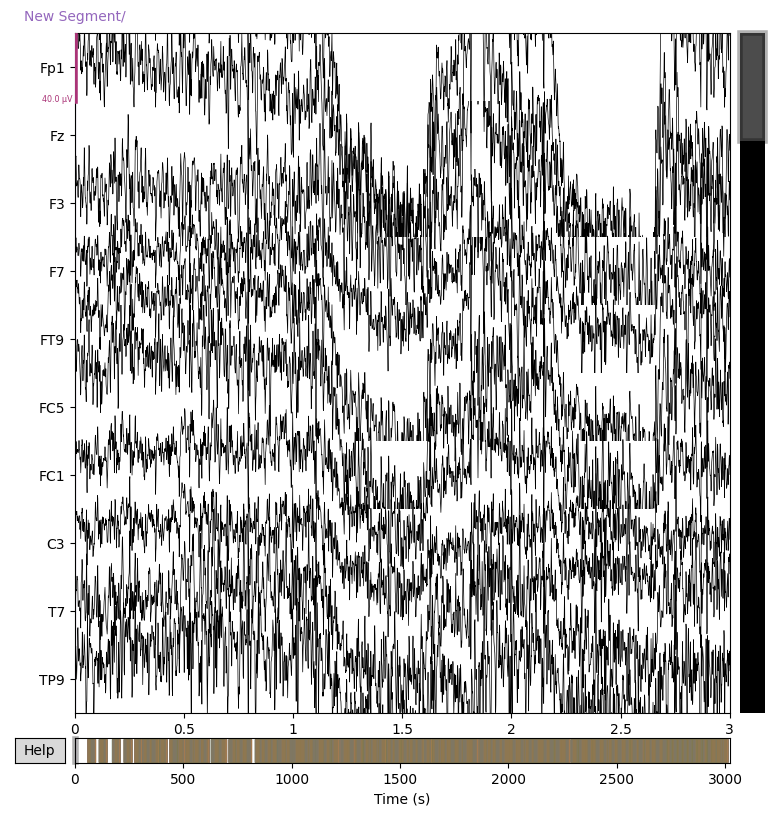

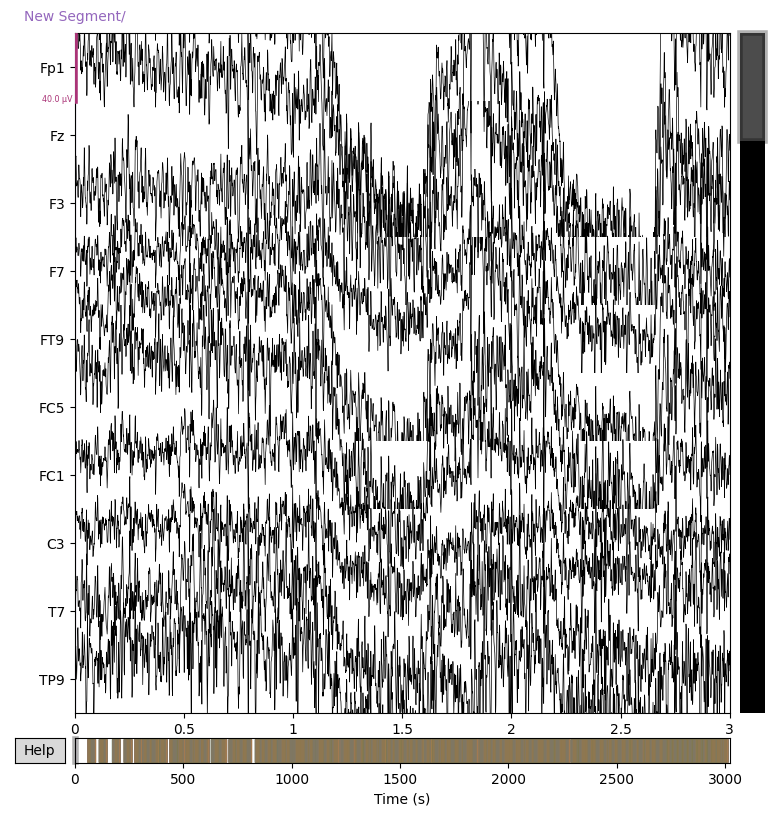

In [13]:
#Plot di 3 secondi di 10 canali dell'EEG
raw.plot(duration = 3, n_channels = 10)

Effective window size : 0.256 (s)


C:\Users\Asus\anaconda3\envs\nl2\lib\site-packages\mne\viz\utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


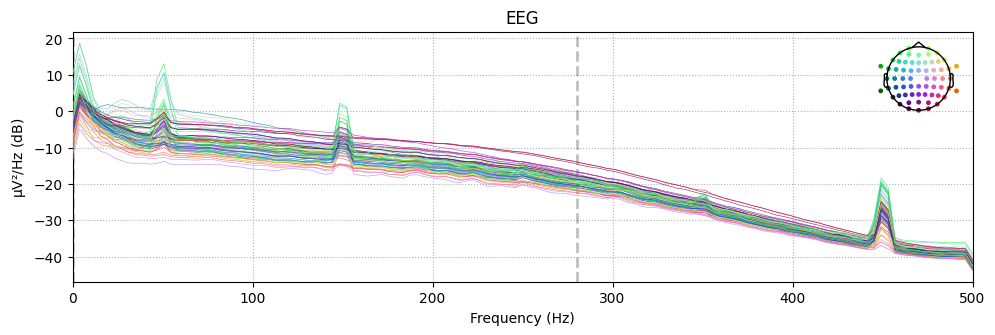

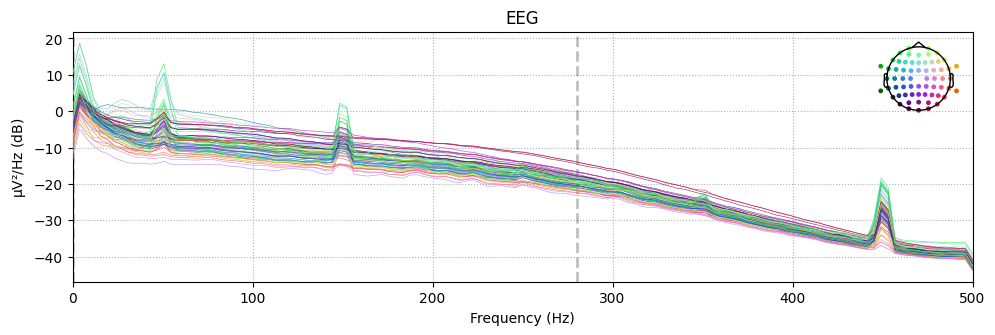

In [14]:
#Plot della Power Spectral Density dei canali
raw.compute_psd().plot()

#### Provate a vedere pazienti e canali diversi!

## Filtri e Resampling

In [ ]:
#Applico un filtro FIR tra 0.1 e 12 Hz per isolare le frequenze rilevanti
filtro=raw.filter(0.1, 12, method='fir')

In [ ]:
reference=filtro.set_eeg_reference(ref_channels='average')

In [ ]:
#Il dataset ha un sample ratio di 1000 Hz, che è troppo alto, quindi faccio un resampling e lo porto a 250 Hz
resample=reference.copy().resample(sfreq=250)
notch=resample.copy().notch_filter(freqs=10)

## ICA - Independent Component Analysis

In [ ]:
#Per utilizzare l'ICA è consigliato applicare un filtro passa-alto di 1 Hz
preica=notch.copy().filter(l_freq=1., h_freq=None)

In [ ]:
#Imposto la bipolar reference
#Uso i canali prefrontali per costruire un nuovo canale artificiale che sostituirà l'EOG nella ricerca di artefatti oculari

bipolar_ref=mne.set_bipolar_reference(preica, 'Fp1', 'Fp2', ch_name='Reference', drop_refs=False)
reconst_raw=bipolar_ref.copy()
  

In [ ]:
ica = ICA(n_components=15, max_iter='auto', random_state=97)
ica.fit(bipolar_ref)
eog_indices, eog_scores = ica.find_bads_eog(bipolar_ref, ch_name='Reference')
ica.exclude = eog_indices
ica.apply(reconst_raw)
    

In [ ]:
#Rimuovo il canale di reference perchè non mi serve più
final_raw=reconst_raw.drop_channels('Reference')